# Labo 5

In [1]:
%pip install tf_keras_vis tflite-support-nightly

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'C:\Users\cfont\.virtualenvs\pythonProject\Scripts\python.exe -m pip install --upgrade pip' command.


## Database creation

In [2]:
import os
import pandas as pd
from glob import glob

def create_dataframe_from_directories(path):
    data = []

    for label_dir in os.listdir(path):
        if os.path.isfile(label_dir):
            continue

        label_path_path = os.path.join(path, label_dir)
        for file in os.listdir(label_path_path):
            data.append([os.path.join(label_path_path, file), label_dir])

    return pd.DataFrame(data, columns = ["path", "label"])

In [3]:
train_df = create_dataframe_from_directories(os.path.join(".","data"))

In [4]:
LABEL_NAMES = pd.unique(train_df['label'])
LABEL_NAMES

array(['bus', 'cars', 'vans'], dtype=object)

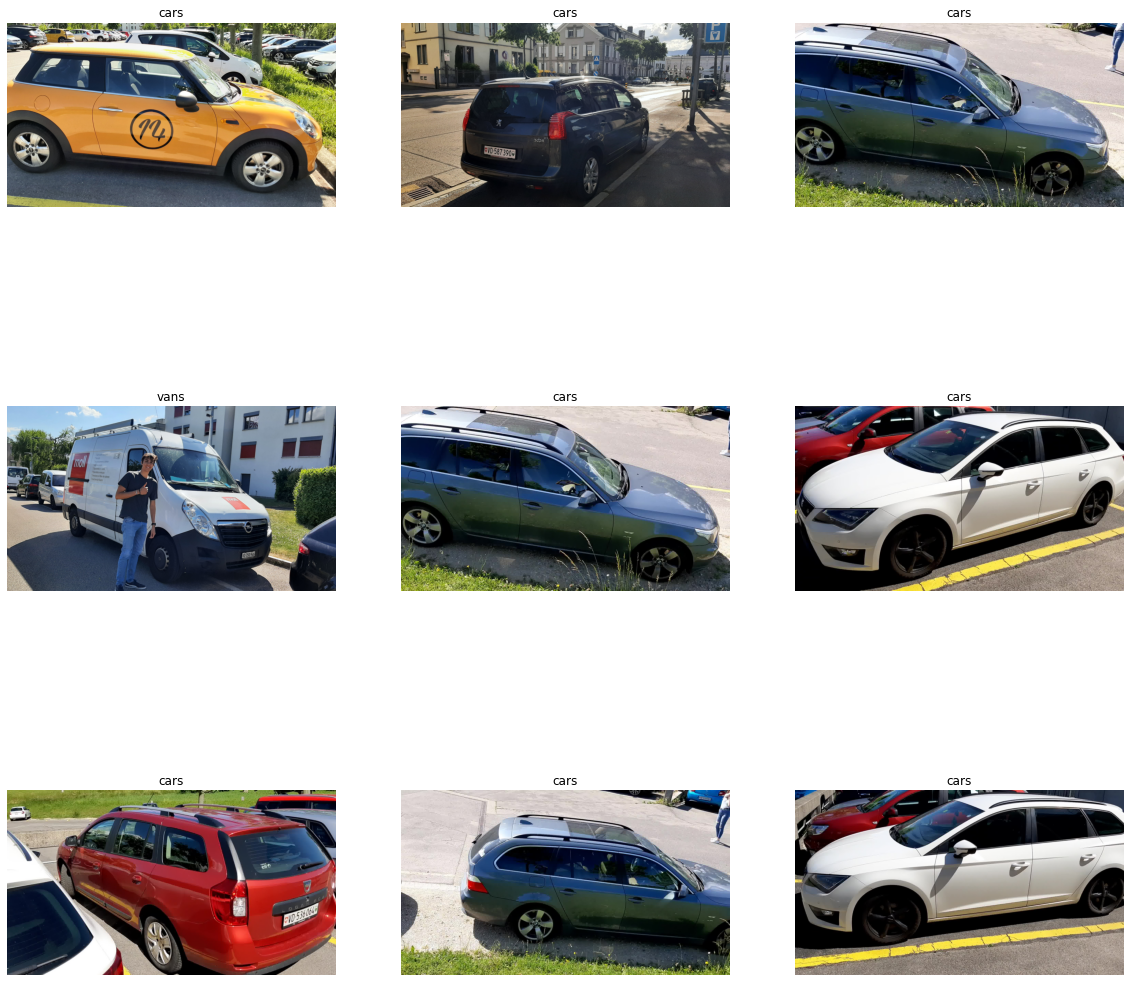

In [25]:
import matplotlib.pyplot as plt
import PIL
import PIL.Image

plt.figure(figsize=(20, 20))

i = 0
for _, rowdata in train_df.sample(frac=1).head(9).iterrows():
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(PIL.Image.open(rowdata.path))
    plt.title(rowdata.label)
    plt.axis("off")
    i += 1

# Dataset exploration

In [26]:
df_counts = train_df.groupby(["label"])["label"].count()
df_counts

label
bus      13
cars    238
vans     36
Name: label, dtype: int64

label
bus     AxesSubplot(0.125,0.125;0.775x0.755)
cars    AxesSubplot(0.125,0.125;0.775x0.755)
vans    AxesSubplot(0.125,0.125;0.775x0.755)
Name: label, dtype: object

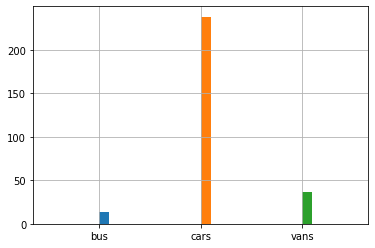

In [27]:
(train_df.groupby(["label"])["label"]).hist()

# Preprocessing steps

In [39]:
from tensorflow.keras.layers import (
    Resizing, Rescaling, RandomFlip, RandomRotation
)

from tensorflow.keras import Sequential

import numpy as np

IMG_HEIGHT = 224
IMG_WIDTH = 224

image_preprocesses = Sequential([
    Resizing(IMG_HEIGHT, IMG_WIDTH, crop_to_aspect_ratio=True),
    Rescaling(1. / 255)
])

image_augmentations = Sequential([
    RandomFlip("horizontal_and_vertical"),
    RandomRotation(0.2),
    # TODO: choose some image augmentations layers
    # see which keras layers you can use
    # The kind of layers you will want to use starts with "Random".
    # See the following page for more information on data augmentation :
    # https://www.tensorflow.org/tutorials/images/data_augmentation
])

def open_images(paths):
    return np.stack([
        open_image(path) for path in paths
    ])

def open_image(path):
    with PIL.Image.open(path) as image:
        opened_img = image_preprocesses(np.asarray(image))

    return opened_img

def augment_image(image):
    return image_augmentations(image)


train_df["path"].map(lambda x: print(x))
train_df['image'] = train_df.apply(lambda row: augment_image(open_image(row["path"])), axis=1)

.\data\bus\20220525_162701(0).jpg
.\data\bus\20220525_162701.jpg
.\data\bus\20220525_162702(0).jpg
.\data\bus\20220525_162702(1).jpg
.\data\bus\20220525_162702.jpg
.\data\bus\20220525_162705.jpg
.\data\bus\20220525_162706.jpg
.\data\bus\20220525_162707(0).jpg
.\data\bus\20220525_162707.jpg
.\data\bus\20220525_162709.jpg
.\data\bus\20220525_162710.jpg
.\data\bus\20220525_163113.jpg
.\data\bus\20220525_163114.jpg
.\data\cars\20220525_160720.jpg
.\data\cars\20220525_160937.jpg
.\data\cars\20220525_160939.jpg
.\data\cars\20220525_160940.jpg
.\data\cars\20220525_160943.jpg
.\data\cars\20220525_160958.jpg
.\data\cars\20220525_161015.jpg
.\data\cars\20220525_161019.jpg
.\data\cars\20220525_161022.jpg
.\data\cars\20220525_161023.jpg
.\data\cars\20220525_161025.jpg
.\data\cars\20220525_161036.jpg
.\data\cars\20220525_161039.jpg
.\data\cars\20220525_161041.jpg
.\data\cars\20220525_161043.jpg
.\data\cars\20220525_161046.jpg
.\data\cars\20220525_161050.jpg
.\data\cars\20220525_161052.jpg
.\data\ca

In [42]:

def open_images(paths):
    return np.stack([
        open_image(path) for path in paths
    ])

def open_image(path):
    with PIL.Image.open(path) as image:
        opened_img = image_preprocesses(np.asarray(image))

    return opened_img

def augment_images(images):
    return np.stack([
        image_augmentations(img) for img in images
    ])

train_df['image'] = train_df.apply(lambda row: augment_image(open_image(row["path"])), axis=1)

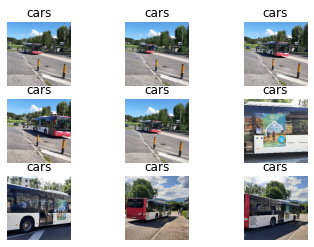

In [43]:
#plt.figure(figsize=(20, 20))

i = 0
for image in train_df.head(9)["image"]:
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.title(rowdata.label)
    plt.axis("off")
    i += 1

## Define model

In [12]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import (
    GlobalAveragePooling2D,
    Dense,
    Dropout
)

def get_model():
    base_model = MobileNetV2(
        input_shape=(224, 224, 3),
        weights='imagenet',
        include_top=False
    )

    # TODO à mettre ici ou en-dessous?
    base_model.trainable = False
    layers = base_model.output

    added_layers = [
        # important, we need global average pooling instead of flatten for class activation map later on
        GlobalAveragePooling2D(),
        Dropout(0.2),
        Dense(3)
    ]

    model = Model(inputs=base_model.input, outputs=Sequential(added_layers)(layers))

    # TODO: freeze layers


    model.compile(
      optimizer = RMSprop(),
      loss = SparseCategoricalCrossentropy(),
      metrics = ['acc']
    )

    return model

In [13]:
get_model().summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                             

# Model training

**TODO**: cross-validate your model, you can base yourself on the code from the first part of this practical work

**NOTE**: you shouldn't augment validations images. What we want to evaluate is the performances on "real" images, not on images that are augmented and change all the time

In [44]:
from tensorflow.keras.layers import Resizing, Rescaling
from tensorflow.keras import Sequential

IMG_HEIGHT = 224
IMG_WIDTH = 224

image_preprocesses = Sequential([
    Resizing(IMG_HEIGHT, IMG_WIDTH, crop_to_aspect_ratio=True),
    Rescaling(1. / 255)
])

In [45]:
def open_images(paths):
    images = []
    for path in paths:
        with PIL.Image.open(path) as image:
            images.append(image_preprocesses(np.asarray(image)))

    return np.array(images)

In [46]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

shuffled_dataset = train_df.sample(frac=1, random_state=1234).reset_index(drop=True)

dataset_paths = shuffled_dataset['path'].to_numpy()
dataset_labels = shuffled_dataset['label'].to_numpy()

total_train_paths, test_paths, total_train_labels, test_labels = train_test_split(
    dataset_paths, dataset_labels, test_size=0.2, random_state=1234
)

# We need to convert from string labels to integers
label_encoder = LabelEncoder()
label_encoder.fit(dataset_labels)
total_train_labels = label_encoder.transform(total_train_labels)
test_labels = label_encoder.transform(test_labels)

NB_EPOCHS = 4

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for train_index, val_index in KFold(n_splits=5).split(total_train_paths, total_train_labels):
    train_images = open_images(total_train_paths[train_index])
    train_labels = total_train_labels[train_index]

    val_images = open_images(total_train_paths[val_index])
    val_labels = total_train_labels[val_index]

    model = get_model() # We reinitialize the model

    history = model.fit(
        x=train_images,
        y=train_labels,
        batch_size=32,
        validation_data=[val_images, val_labels],
        epochs=NB_EPOCHS,
    )

    train_losses.append(history.history['loss'])
    val_losses.append(history.history['val_loss'])
    train_accuracies.append(history.history['acc'])
    val_accuracies.append(history.history['val_acc'])

Epoch 1/4
6/6 [==============================] - 7s 798ms/step - loss: 3.0058 - acc: 0.7869 - val_loss: 2.4348 - val_acc: 0.7826
Epoch 2/4
6/6 [==============================] - 4s 679ms/step - loss: 1.1766 - acc: 0.8470 - val_loss: 0.8837 - val_acc: 0.7826
Epoch 3/4
6/6 [==============================] - 4s 777ms/step - loss: 1.0347 - acc: 0.7869 - val_loss: 0.9792 - val_acc: 0.7826
Epoch 4/4
6/6 [==============================] - 4s 650ms/step - loss: 0.8945 - acc: 0.7869 - val_loss: 0.9792 - val_acc: 0.7826
Epoch 1/4
6/6 [==============================] - 7s 788ms/step - loss: 2.9957 - acc: 0.7158 - val_loss: 3.1204 - val_acc: 0.8043
Epoch 2/4
6/6 [==============================] - 4s 668ms/step - loss: 2.5696 - acc: 0.8306 - val_loss: 2.8270 - val_acc: 0.8043
Epoch 3/4
6/6 [==============================] - 4s 638ms/step - loss: 1.9577 - acc: 0.8361 - val_loss: 1.5870 - val_acc: 0.8478
Epoch 4/4
6/6 [==============================] - 4s 636ms/step - loss: 1.5479 - acc: 0.8197 - val

In [48]:
def plot_kfold_mean_performance(ax, train_performances, val_performances, measure_name):
    train_mean = np.mean(train_performances, axis=0)
    val_mean = np.mean(val_performances, axis=0)
    train_sd = np.std(train_performances, axis=0)
    val_sd = np.std(val_performances, axis=0)

    ax.fill_between(np.arange(NB_EPOCHS), train_mean, train_mean+train_sd, facecolor='blue', alpha=0.5, label='Train')
    ax.fill_between(np.arange(NB_EPOCHS), train_mean, train_mean-train_sd, facecolor='blue', alpha=0.5)

    ax.fill_between(np.arange(NB_EPOCHS), val_mean, val_mean+val_sd, facecolor='orange', alpha=0.5, label='Val')
    ax.fill_between(np.arange(NB_EPOCHS), val_mean, val_mean-val_sd, facecolor='orange', alpha=0.5)

    ax.set_xticks(np.arange(NB_EPOCHS))

    ax.set_ylabel(measure_name)
    ax.set_xlabel('Number of epochs')
    #pl.title(str(K)+'-fold CV with '+str(n)+' hidden neurons')
    ax.legend()
    ax.grid()


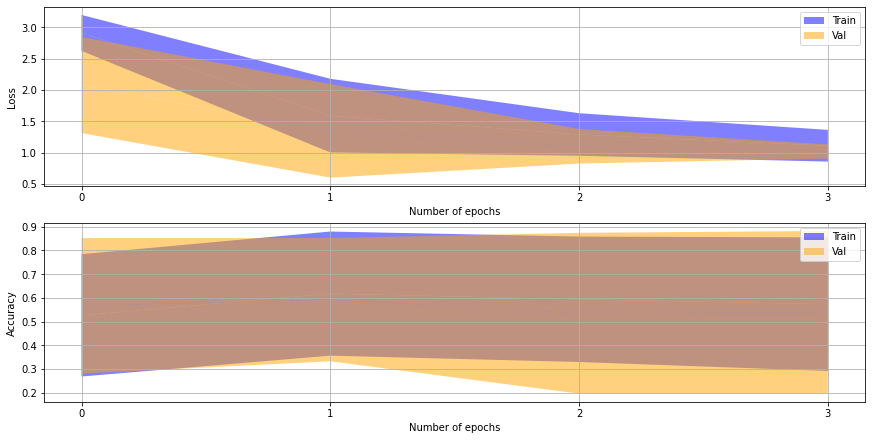

In [49]:
import matplotlib.pyplot as pl

fig, axs = plt.subplots(2, 1, constrained_layout=True, figsize=(12,6))

plot_kfold_mean_performance(axs[0], train_losses, val_losses, "Loss")
plot_kfold_mean_performance(axs[1], train_accuracies, val_accuracies, "Accuracy")

# Results

**TODO**: plot the results from your crossvalidation

In [ ]:
# First retrain model on all the training data
train_images = open_images(total_train_paths)
train_labels = total_train_labels

model = get_model() # We reinitialize the model

history = model.fit(
    x=train_images,
    y=train_labels,
    batch_size=32,
    epochs=NB_EPOCHS,
)

## Evaluate model on test set

**TODO**: when you've selected a final model, evaluate its performances (f-score, confusion matrix, ...) on your test set

### Display some misclassified images

**TODO**: display some misclassified images to be able to see what images are difficult for the model

## Use grad-cam to inspect how the model classify
Here we can see an heatmap of the regions that activates the model the most.

### For more information:
- tf-keras-vis documentation: https://keisen.github.io/tf-keras-vis-docs/
- Grad-cam paper: https://arxiv.org/pdf/1610.02391.pdf
- Grad-cam++ paper: https://arxiv.org/pdf/1710.11063.pdf

**NOTE**: maybe you will need to adapt some variable names based on your code above. For example, _model_ should be the model trained on all the training data.

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm
from tensorflow.keras.applications import MobileNetV2
from tf_keras_vis.gradcam_plus_plus import GradcamPlusPlus
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from tf_keras_vis.utils.scores import CategoricalScore

# Create GradCAM++ object
gradcam = GradcamPlusPlus(
    model,
    model_modifier=ReplaceToLinear(),
    clone=True,
)

nb_images_per_class = 10

fig, axs = plt.subplots(nb_images_per_class, len(LABEL_NAMES), figsize=(len(LABEL_NAMES) * 5, nb_images_per_class * 5))

for label_idx, label_name in enumerate(LABEL_NAMES):
    axs[0,label_idx].set_title(label_name, loc='center', y=1.1)

    i = 0
    for _, rowdata in train_df[train_df['label'] == label_name].sample(frac=1).head(nb_images_per_class).iterrows():
        img = open_image(rowdata.path)
        pred = model(np.expand_dims(img, axis=0))

        # Generate cam with GradCAM++
        score = CategoricalScore(np.argmax(pred))
        cam = gradcam(score, img)
        heatmap = np.uint8(cm.jet(cam[0])[..., :3] * 255)

        axs[i,label_idx].imshow(img, vmin=0, vmax=1)
        axs[i,label_idx].imshow(heatmap, cmap='jet', alpha=0.5) # overlay
        axs[i,label_idx].axis("off")

        i += 1

### Display some misclassified images

**TODO**: display some misclassified images to be able to see what images are difficult for the model

## Use grad-cam to inspect how the model classify
Here we can see an heatmap of the regions that activates the model the most.

### For more information:
- tf-keras-vis documentation: https://keisen.github.io/tf-keras-vis-docs/
- Grad-cam paper: https://arxiv.org/pdf/1610.02391.pdf
- Grad-cam++ paper: https://arxiv.org/pdf/1710.11063.pdf

**NOTE**: maybe you will need to adapt some variable names based on your code above. For example, _model_ should be the model trained on all the training data.

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm
from tensorflow.keras.applications import MobileNetV2
from tf_keras_vis.gradcam_plus_plus import GradcamPlusPlus
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from tf_keras_vis.utils.scores import CategoricalScore

# Create GradCAM++ object
gradcam = GradcamPlusPlus(
    model,
    model_modifier=ReplaceToLinear(),
    clone=True,
)

nb_images_per_class = 10

fig, axs = plt.subplots(nb_images_per_class, len(LABEL_NAMES), figsize=(len(LABEL_NAMES) * 5, nb_images_per_class * 5))

for label_idx, label_name in enumerate(LABEL_NAMES):
    axs[0,label_idx].set_title(label_name, loc='center', y=1.1)

    i = 0
    for _, rowdata in train_df[train_df['label'] == label_name].sample(frac=1).head(nb_images_per_class).iterrows():
        img = open_image(rowdata.path)
        pred = model(np.expand_dims(img, axis=0))

        # Generate cam with GradCAM++
        score = CategoricalScore(np.argmax(pred))
        cam = gradcam(score, img)
        heatmap = np.uint8(cm.jet(cam[0])[..., :3] * 255)

        axs[i,label_idx].imshow(img, vmin=0, vmax=1)
        axs[i,label_idx].imshow(heatmap, cmap='jet', alpha=0.5) # overlay
        axs[i,label_idx].axis("off")

        i += 1

### Grad-cam on misclassified images

**TODO**: now do the same than above, but with the misclassified images. You shouldn't change anything pertaining to grad-cam besides on which image and prediction you do it

**TODO**: try to determine what caused the misclassifcations and what you can do about it